In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline


### Step 1: Obtaining cleaned & lemmatized dataset

In [31]:
data_set = '../data/03_data_post_EDA.csv'

df = pd.read_csv(data_set)

quick view at dataframe

In [32]:
df.head()

,comment_id,parent_id,post_id,body,score,post_title,subreddit,body_cleaned,body_cleaned_lemmatized,comment_length,sentiment_score,emotional_tone
0,gbgsbi4,t3_jptqj9,t3_jptqj9,"As you all celebrate or commiserate, please he...",1,Joe Biden elected president of the United States,news,celebrate commiserate please help us reporting...,celebrate commiserate please help reporting co...,138,0.15,Neutral
1,gbhfdv2,t3_jptqj9,t3_jptqj9,"Congratulations USA! From Brazil, I hope Bolso...",172,Joe Biden elected president of the United States,news,Congratulations USA Brazil hope Bolsonaro next...,congratulation usa brazil hope bolsonaro next ...,12,0.00,Neutral
2,gbgt3me,t3_jptqj9,t3_jptqj9,"Fox News just called it a couple minutes ago, ...",8749,Joe Biden elected president of the United States,news,Fox News called couple minutes ago know real,fox news call couple minute ago know real,14,0.20,Neutral
3,gbgvvs7,t3_jptqj9,t3_jptqj9,"""You were expecting Nevada to decide the elect...",16552,Joe Biden elected president of the United States,news,You expecting Nevada decide election ME PENNSY...,you expect nevada decide election me pennsylvania,13,0.00,Neutral
4,gbgr8hw,t3_jptqj9,t3_jptqj9,"Is it 100% confirmed, as in nothing can take t...",3176,Joe Biden elected president of the United States,news,100 confirmed nothing take away,100 confirm nothing take away,11,0.40,Positive


### Assign 1 = r/TheOnion & 0 = r/news to prevent confusion

In [33]:
df['subreddit_binary'] = df['subreddit'].map({'TheOnion': 1, 'news': 0})

Quick check in place

In [34]:
df[['subreddit_binary','subreddit']]

,subreddit_binary,subreddit
0,0,news
1,0,news
2,0,news
3,0,news
4,0,news
...,...,...
37774,1,TheOnion
37775,1,TheOnion
37776,1,TheOnion
37777,1,TheOnion


Check for Null/NaN values

In [35]:
df.isnull().sum()

comment_id                  0
parent_id                   0
post_id                     0
body                        0
score                       0
post_title                  0
subreddit                   0
body_cleaned                0
body_cleaned_lemmatized    20
comment_length              0
sentiment_score             0
emotional_tone              0
subreddit_binary            0
dtype: int64

Remove Null/NaN values

In [36]:
df = df.dropna(subset=['body_cleaned_lemmatized'])
df.isnull().sum()

comment_id                 0
parent_id                  0
post_id                    0
body                       0
score                      0
post_title                 0
subreddit                  0
body_cleaned               0
body_cleaned_lemmatized    0
comment_length             0
sentiment_score            0
emotional_tone             0
subreddit_binary           0
dtype: int64

## Step 2: Transforming and Modelling

implement transformers for the 5 proposed models, sharing the same y data set

In [37]:
cvec = CountVectorizer()

X_cvec = cvec.fit_transform(df['body_cleaned_lemmatized'])
y = df['subreddit_binary']
# Split the data into training and testing sets
X_train_cvec, X_test_cvec, y_train_cvec, y_test_cvec = train_test_split(X_cvec, y, test_size=0.2, random_state=42,stratify=y)

In [38]:
tvec = TfidfVectorizer()

X_tvec = tvec.fit_transform(df['body_cleaned_lemmatized'])
# Split the data into training and testing sets
X_train_tvec, X_test_tvec, y_train_tvec, y_test_tvec = train_test_split(X_tvec, y, test_size=0.2, random_state=42,stratify=y)

Evaluation of 1st model Logistic Regression with CountVectorizor(cvec) on test data alongside confusion matrix for reference. 

Scoring metrics used are Accuracy, Precision, Sensitivity/Recall, F1_score.


Accuracy: 0.8339512711864406
Precision 0.8241418120427687
Sensitivity: 0.8232152894884767
f1_score: 0.8236782902137233


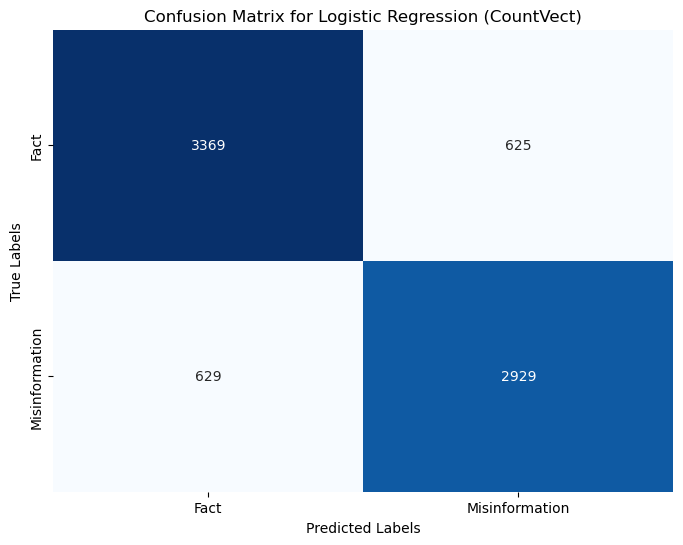

In [39]:


# Initialize and train the logistic regression model
logistic_regression = LogisticRegression(max_iter= 10000)
logistic_regression.fit(X_train_cvec, y_train_cvec)


# Predict labels for the test set
y_pred_lr_cvec = logistic_regression.predict(X_test_cvec)

# Evaluate the model
accuracy_lr = accuracy_score(y_test_cvec, y_pred_lr_cvec)
print("Accuracy:", accuracy_lr)

tn, fp, fn, tp = confusion_matrix(y_test_cvec, y_pred_lr_cvec).ravel()

print('Precision', tp/(tp+fp))
print('Sensitivity:' , tp / (tp+fn))
print('f1_score:', 2*tp / (2*tp + fp + fn))

cm_lr = confusion_matrix(y_test_cvec, y_pred_lr_cvec)

# Define class labels
class_labels = [ 'Fact','Misinformation']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
plt.title('Confusion Matrix for Logistic Regression (CountVect)')
plt.show()


Evaluation of 1st model k-Nearest Classifier with CountVectorizor(cvec) on test data alongside confusion matrix for reference. 

Scoring metrics used are Accuracy, Precision, Sensitivity/Recall, F1_score.


Accuracy: 0.5439618644067796
Precision 0.5086890243902439
Sensitivity: 0.9378864530635188
f1_score: 0.6596165250049417


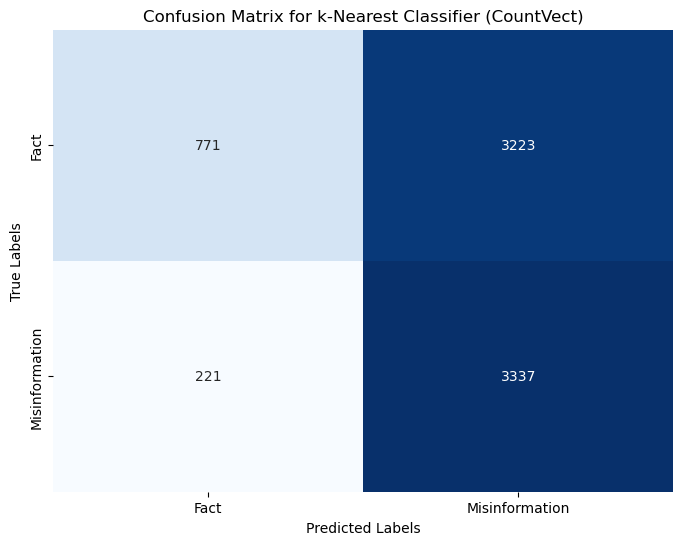

In [40]:

# Initialize and train the KNN classifier
k = 15 # Number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train_cvec, y_train_cvec)

# Predict labels for the test set
y_pred_knn_cvec = knn_classifier.predict(X_test_cvec)

# Evaluate the model
accuracy_knn = accuracy_score(y_test_cvec, y_pred_knn_cvec)
print("Accuracy:", accuracy_knn)

tn, fp, fn, tp = confusion_matrix(y_test_cvec, y_pred_knn_cvec).ravel()

print('Precision', tp/(tp+fp))
print('Sensitivity:' , tp / (tp+fn))
print('f1_score:', 2*tp / (2*tp + fp + fn))


cm_knn = confusion_matrix(y_test_cvec, y_pred_knn_cvec)

# Define class labels
class_labels = [ 'Fact','Misinformation']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
plt.title('Confusion Matrix for k-Nearest Classifier (CountVect)')
plt.show()

Evaluation of 1st model Multinomial Naive-Bayes Classifer with CountVectorizor(cvec) on test data alongside confusion matrix for reference. 

Scoring metrics used are Accuracy, Precision, Sensitivity/Recall, F1_score.


Accuracy: 0.819385593220339
Precision 0.8498086734693877
Sensitivity: 0.7490163012928611
f1_score: 0.7962354347176576


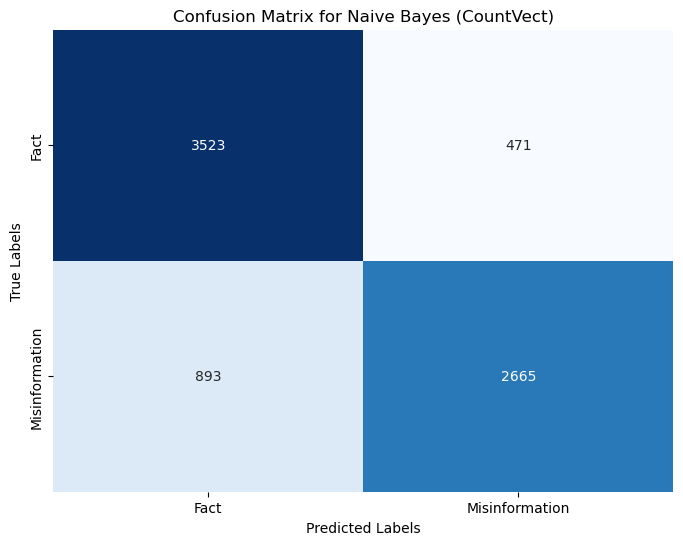

In [41]:
# Initialize and train the Naive Bayes classifier
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_cvec, y_train_cvec)

# Predict labels for the test set
y_pred_nb_cvec = naive_bayes_classifier.predict(X_test_cvec)

# Evaluate the model
accuracy_nb = accuracy_score(y_test_cvec, y_pred_nb_cvec)
print("Accuracy:", accuracy_nb)

tn, fp, fn, tp = confusion_matrix(y_test_cvec, y_pred_nb_cvec).ravel()

print('Precision', tp/(tp+fp))
print('Sensitivity:' , tp / (tp+fn))
print('f1_score:', 2*tp / (2*tp + fp + fn))


cm_nb = confusion_matrix(y_test_cvec, y_pred_nb_cvec)

# Define class labels
class_labels = [ 'Fact','Misinformation']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
plt.title('Confusion Matrix for Naive Bayes (CountVect)')
plt.show()

Evaluation of 1st model Bagging Classifier with CountVectorizor(cvec) on test data alongside confusion matrix for reference. 

Scoring metrics used are Accuracy, Precision, Sensitivity/Recall, F1_score.


Accuracy: 0.7673463983050848
Precision 0.7523115718688709
Sensitivity: 0.7546374367622259
f1_score: 0.7534727094149011


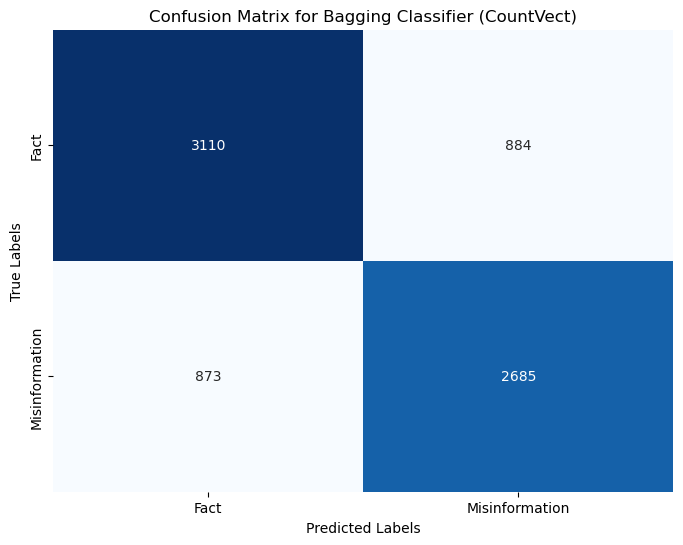

In [42]:
# Initialize and train the Bagging Classifier
bagging_classifier = BaggingClassifier( n_estimators=15, random_state=42)
bagging_classifier.fit(X_train_cvec, y_train_cvec)

# Predict labels for the test set
y_pred_bag_cvec = bagging_classifier.predict(X_test_cvec)

# Evaluate the model
accuracy_bag = accuracy_score(y_test_cvec, y_pred_bag_cvec)
print("Accuracy:", accuracy_bag)

tn, fp, fn, tp = confusion_matrix(y_test_cvec, y_pred_bag_cvec).ravel()

print('Precision', tp/(tp+fp))
print('Sensitivity:' , tp / (tp+fn))
print('f1_score:', 2*tp / (2*tp + fp + fn))

cm_bag = confusion_matrix(y_test_cvec, y_pred_bag_cvec)

# Define class labels
class_labels = [ 'Fact','Misinformation']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bag, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
plt.title('Confusion Matrix for Bagging Classifier (CountVect)')
plt.show()

Evaluation of 1st model XGBoost Classifier with CountVectorizor(cvec) on test data alongside confusion matrix for reference. 

Scoring metrics used are Accuracy, Precision, Sensitivity/Recall, F1_score.


Accuracy: 0.7114671610169492
Precision 0.8712977921378567
Sensitivity: 0.4547498594716133
f1_score: 0.5975992613111727


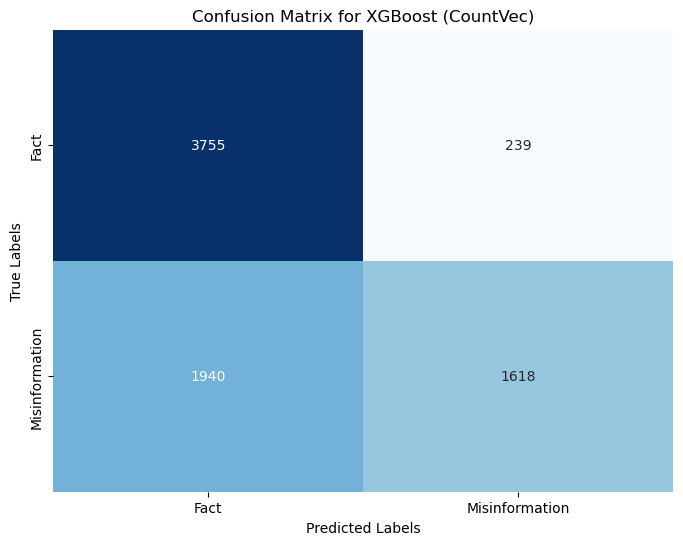

In [43]:
# Creating XGBClassifier objects
xgb = XGBClassifier(max_depth=5, learning_rate=0.1, objective='binary:logistic', eval_metric='error')

# Training the model
xgb.fit(X_train_cvec, y_train_cvec)

# Predicting on the test set
y_pred_xgb = xgb.predict(X_test_cvec)

# Calculating accuracy
accuracy = accuracy_score(y_test_cvec, y_pred_xgb)
print("Accuracy:", accuracy)

# Calculating other metrics
tn, fp, fn, tp = confusion_matrix(y_test_cvec, y_pred_xgb).ravel()

print('Precision', tp/(tp+fp))
print('Sensitivity:', tp / (tp + fn))
print('f1_score:', 2 * tp / (2 * tp + fp + fn))

# Plot confusion matrix
cm_xgb = confusion_matrix(y_test_cvec, y_pred_xgb)
class_labels = ['Fact', 'Misinformation']
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
plt.title('Confusion Matrix for XGBoost (CountVec)')
plt.show()

Evaluation of 1st model Logistic Regression with Td-idf Vectorizor(tvec) on test data alongside confusion matrix for reference. 

Scoring metrics used are Accuracy, Precision, Sensitivity/Recall, F1_score.


Accuracy: 0.8358050847457628
Precision 0.8386908240794857
Sensitivity: 0.8066329398538504
f1_score: 0.8223495702005731


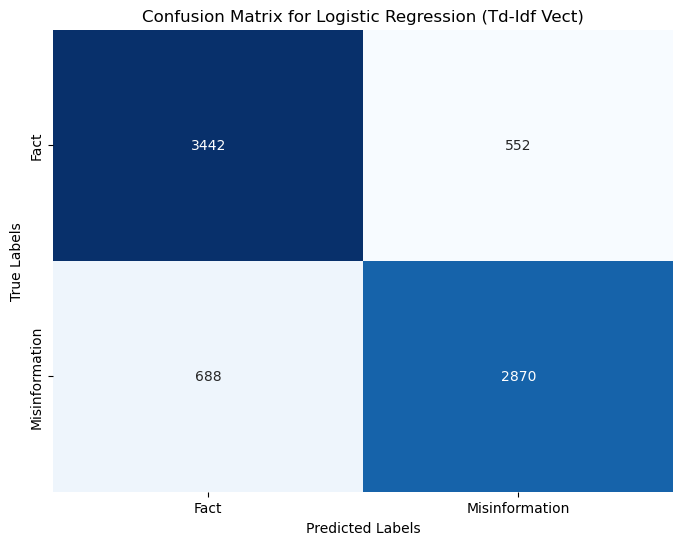

In [44]:
# Initialize and train the logistic regression model
logistic_regression = LogisticRegression(max_iter= 10000)
logistic_regression.fit(X_train_tvec, y_train_tvec)

# Predict labels for the test set
y_pred_lr_tvec = logistic_regression.predict(X_test_tvec)

# Evaluate the model
accuracy_lr = accuracy_score(y_test_tvec, y_pred_lr_tvec)
print("Accuracy:", accuracy_lr)

tn, fp, fn, tp = confusion_matrix(y_test_tvec, y_pred_lr_tvec).ravel()

print('Precision', tp/(tp+fp))
print('Sensitivity:' , tp / (tp+fn))
print('f1_score:', 2*tp / (2*tp + fp + fn))

cm_lr = confusion_matrix(y_test_tvec, y_pred_lr_tvec)

# Define class labels
class_labels = [ 'Fact','Misinformation']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
plt.title('Confusion Matrix for Logistic Regression (Td-Idf Vect)')
plt.show()


Evaluation of 1st model k-Nearest Classifier with Td-idf Vectorizor(tvec) on test data alongside confusion matrix for reference. 

Scoring metrics used are Accuracy, Precision, Sensitivity/Recall, F1_score.


Accuracy: 0.4831832627118644
Precision 0.4766165107767385
Sensitivity: 0.9881956155143339
f1_score: 0.6430727023319616


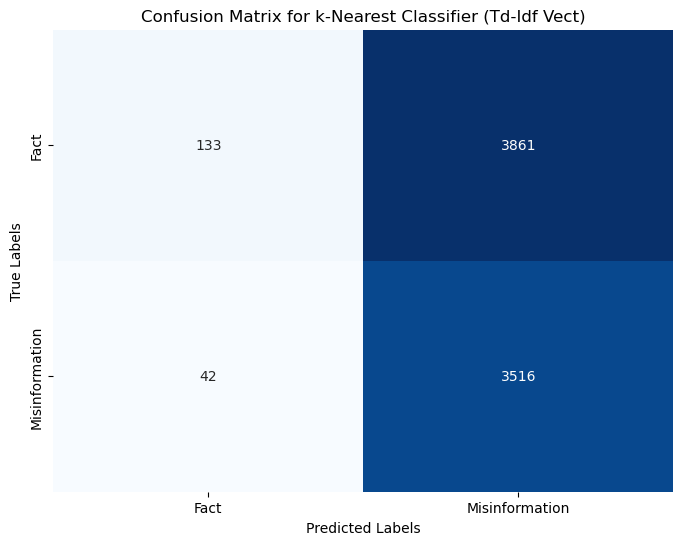

In [45]:

# Initialize and train the KNN classifier
k = 15 # Number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train_tvec, y_train_tvec)

# Predict labels for the test set
y_pred_knn_tvec = knn_classifier.predict(X_test_tvec)

# Evaluate the model
accuracy_knn = accuracy_score(y_test_tvec, y_pred_knn_tvec)
print("Accuracy:", accuracy_knn)

tn, fp, fn, tp = confusion_matrix(y_test_tvec, y_pred_knn_tvec).ravel()

print('Precision', tp/(tp+fp))
print('Sensitivity:' , tp / (tp+fn))
print('f1_score:', 2*tp / (2*tp + fp + fn))


cm_knn = confusion_matrix(y_test_tvec, y_pred_knn_tvec)

# Define class labels
class_labels = [ 'Fact','Misinformation']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
plt.title('Confusion Matrix for k-Nearest Classifier (Td-Idf Vect)')
plt.show()

Evaluation of 1st model Multinomial Naive-Bayes Classifier with Td-idf Vectorizor(tvec) on test data alongside confusion matrix for reference. 

Scoring metrics used are Accuracy, Precision, Sensitivity/Recall, F1_score.


Accuracy: 0.8254766949152542
Precision 0.8672131147540983
Sensitivity: 0.7433951658234963
f1_score: 0.8005447941888619


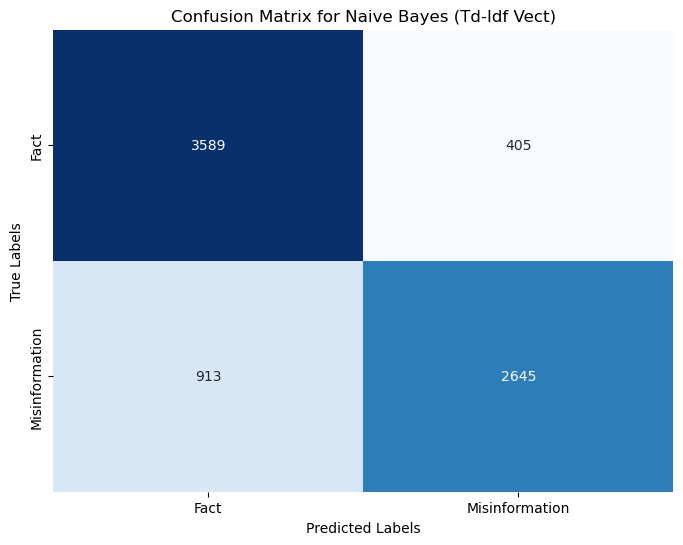

In [46]:
# Initialize and train the Naive Bayes classifier
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tvec, y_train_tvec)

# Predict labels for the test set
y_pred_nb_tvec = naive_bayes_classifier.predict(X_test_tvec)

# Evaluate the model
accuracy_nb = accuracy_score(y_test_tvec, y_pred_nb_tvec)
print("Accuracy:", accuracy_nb)

tn, fp, fn, tp = confusion_matrix(y_test_tvec, y_pred_nb_tvec).ravel()

print('Precision', tp/(tp+fp))
print('Sensitivity:' , tp / (tp+fn))
print('f1_score:', 2*tp / (2*tp + fp + fn))


cm_nb = confusion_matrix(y_test_tvec, y_pred_nb_tvec)

# Define class labels
class_labels = [ 'Fact','Misinformation']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
plt.title('Confusion Matrix for Naive Bayes (Td-Idf Vect)')
plt.show()

Evaluation of 1st model Bagging Classifier with Td-idf Vectorizor(tvec) on test data alongside confusion matrix for reference. 

Scoring metrics used are Accuracy, Precision, Sensitivity/Recall, F1_score.


Accuracy: 0.7789989406779662
Precision 0.789990789069696
Sensitivity: 0.723159078133783
f1_score: 0.7550990462215701


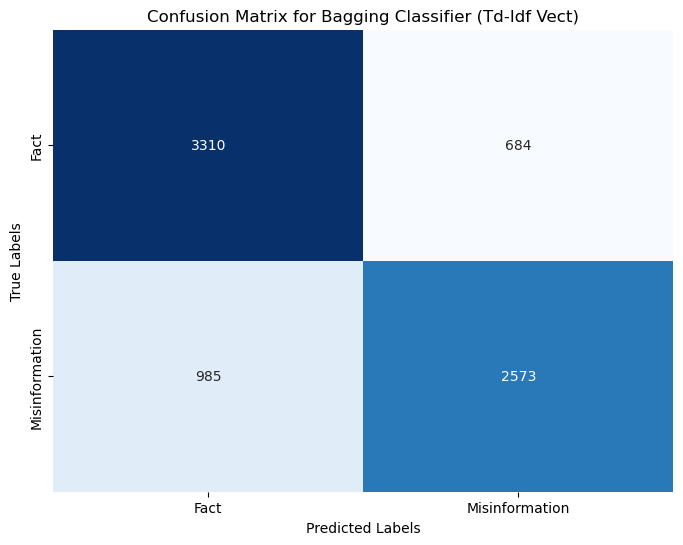

In [47]:
# Initialize and train the Bagging Classifier
bagging_classifier = BaggingClassifier( n_estimators=15, random_state=42)
bagging_classifier.fit(X_train_tvec, y_train_tvec)

# Predict labels for the test set
y_pred_bag_tvec = bagging_classifier.predict(X_test_tvec)

# Evaluate the model
accuracy_bag = accuracy_score(y_test_tvec, y_pred_bag_tvec)
print("Accuracy:", accuracy_bag)

tn, fp, fn, tp = confusion_matrix(y_test_tvec, y_pred_bag_tvec).ravel()

print('Precision', tp/(tp+fp))
print('Sensitivity:' , tp / (tp+fn))
print('f1_score:', 2*tp / (2*tp + fp + fn))

cm_bag = confusion_matrix(y_test_tvec, y_pred_bag_tvec)

# Define class labels
class_labels = [ 'Fact','Misinformation']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bag, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
plt.title('Confusion Matrix for Bagging Classifier (Td-Idf Vect)')
plt.show()

Evaluation of 1st model XGBoost Classifier with Td-idf Vectorizor(tvec) on test data alongside confusion matrix for reference. 

Scoring metrics used are Accuracy, Precision, Sensitivity/Recall, F1_score.


Accuracy: 0.7194120762711864
Precision 0.8729911871435977
Sensitivity: 0.47329960652051717
f1_score: 0.6138144705667943


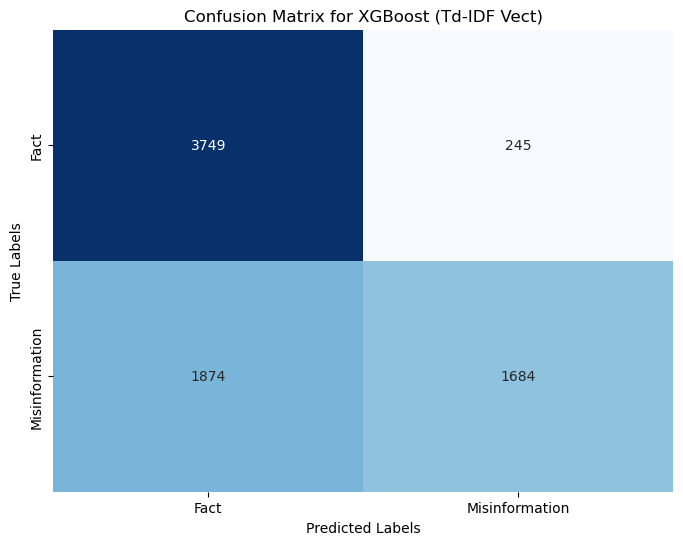

In [48]:
# Creating XGBClassifier objects
xgb = XGBClassifier(max_depth=5, learning_rate=0.1, objective='binary:logistic', eval_metric='error')

# Training the model
xgb.fit(X_train_tvec, y_train_tvec)

# Predicting on the test set
y_pred_xgb = xgb.predict(X_test_tvec)

# Calculating accuracy
accuracy = accuracy_score(y_test_tvec, y_pred_xgb)
print("Accuracy:", accuracy)

# Calculating other metrics
tn, fp, fn, tp = confusion_matrix(y_test_tvec, y_pred_xgb).ravel()

print('Precision', tp/(tp+fp))
print('Sensitivity:', tp / (tp + fn))
print('f1_score:', 2 * tp / (2 * tp + fp + fn))

# Plot confusion matrix
cm_xgb = confusion_matrix(y_test_tvec, y_pred_xgb)
class_labels = ['Fact', 'Misinformation']
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
plt.title('Confusion Matrix for XGBoost (Td-IDF Vect)')
plt.show()

In [49]:
# train_test_split for cval pipeline evaluation below
X = df['body_cleaned_lemmatized']
y = df['subreddit_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [21]:
# Define transformers and models

# Transformer list
transformer_list = ['cvec', 'tvec']

# Model list
model_dict = { 
    'lr': logistic_regression,
    'knn': knn_classifier,
    'nb': naive_bayes_classifier,
    'bag': bagging_classifier,
    'xgb': xgb
}

# Define evaluation metrics
scoring_dict = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}

# Dictionary to store cross-validation scores
cval_dict = {'models': list(model_dict.keys())}

# Loop through transformers
for transformer in transformer_list:
    for scoring_name, scoring in scoring_dict.items():
        transformer_scores = [] # List for scores 
        for model_name, model in model_dict.items():
            # Prepare data
            X_train_set = X_train# Load your X_train_set dataset based on transformer
            y_train_set = y_train # Load your y_train_set dataset based on transformer
            
            # Use appropriate vectorizer based on transformer
            if transformer == 'cvec':
                vectorizer = CountVectorizer()
            elif transformer == 'tvec':
                vectorizer = TfidfVectorizer()
            else:
                raise ValueError("Invalid transformer name")
            
            # Create pipeline
            pipeline = make_pipeline(vectorizer, model)
            
            # Perform cross-validation
            scores = cross_val_score(pipeline, X_train_set, y_train_set, cv=5, scoring=scoring).mean()
            
            # Store scores
            transformer_scores.append(scores.mean())
        
        # Store transformer scores in the dictionary
        cval_dict[f"{transformer}_{scoring_name}"] = transformer_scores

# Convert dictionary to DataFrame
mean_cval_df = pd.DataFrame(cval_dict)
print(mean_cval_df)


  models  cvec_accuracy  cvec_precision  cvec_recall  cvec_f1_score  \
0     lr       0.768834        0.742258     0.780837       0.760433   
1    knn       0.529564        0.500468     0.928744       0.650389   
2     nb       0.769999        0.780215     0.708682       0.741381   
3    bag       0.715901        0.687793     0.727339       0.706666   
4    xgb       0.699139        0.834866     0.447373       0.579627   

   tvec_accuracy  tvec_precision  tvec_recall  tvec_f1_score  
0       0.776433        0.762822     0.761956       0.761644  
1       0.472713        0.470107     0.937005       0.626059  
2       0.774421        0.793643     0.702445       0.744181  
3       0.736396        0.728202     0.702782       0.714966  
4       0.699113        0.838557     0.445013       0.578061  


In [22]:
mean_cval_df

,models,cvec_accuracy,cvec_precision,cvec_recall,cvec_f1_score,tvec_accuracy,tvec_precision,tvec_recall,tvec_f1_score
0,lr,0.768834,0.742258,0.780837,0.760433,0.776433,0.762822,0.761956,0.761644
1,knn,0.529564,0.500468,0.928744,0.650389,0.472713,0.470107,0.937005,0.626059
2,nb,0.769999,0.780215,0.708682,0.741381,0.774421,0.793643,0.702445,0.744181
3,bag,0.715901,0.687793,0.727339,0.706666,0.736396,0.728202,0.702782,0.714966
4,xgb,0.699139,0.834866,0.447373,0.579627,0.699113,0.838557,0.445013,0.578061


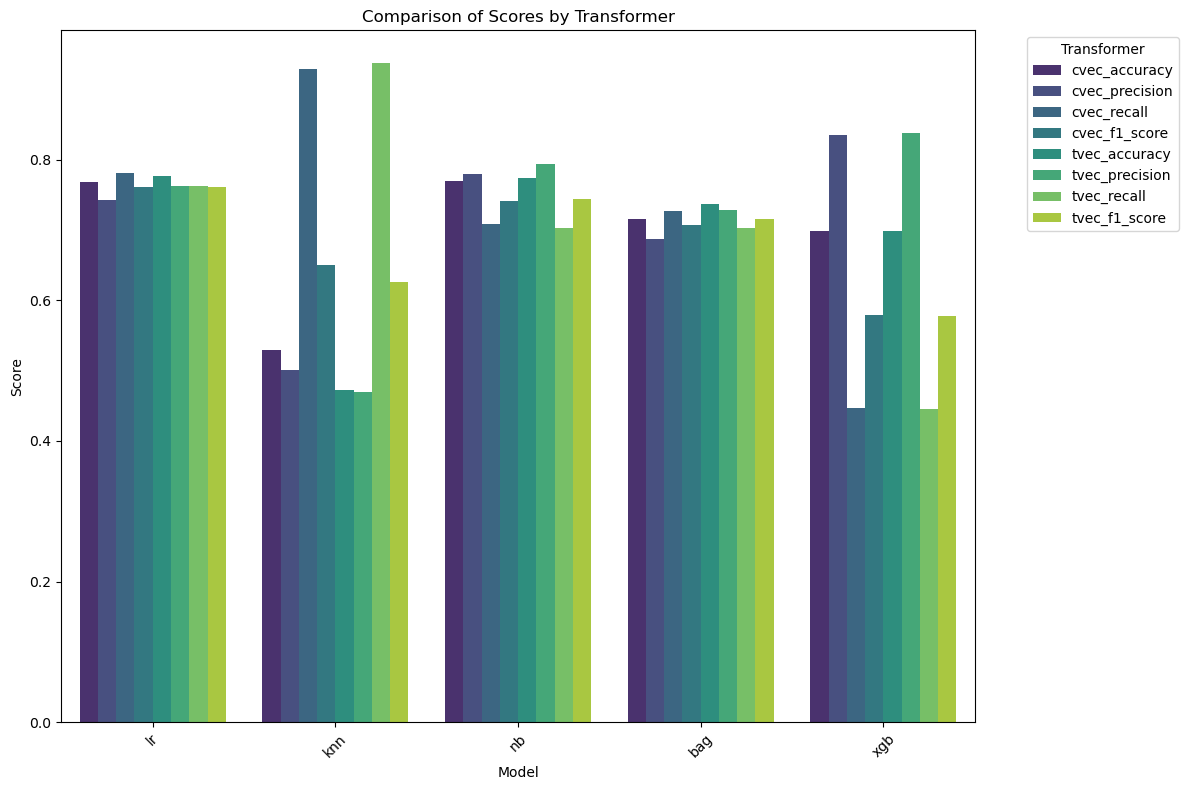

In [27]:


# Melt the DataFrame to convert it to long format for easier plotting
melted_df = pd.melt(mean_cval_df, id_vars='models', var_name='Metric_Transformer', value_name='Score')

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='models', y='Score', hue='Metric_Transformer', data=melted_df, palette='viridis')
plt.title('Comparison of Scores by Transformer')
plt.xticks(rotation=45)
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Transformer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Evaluation

Based on mean_cval_df, CountVectorizor(cvec) proved to be better in most cases (lr, nb, bag for sensitivity and f1_score). Moving forward, cvec will be used as the primary transformer. In addition, logistic regression (lr) and naive bayes (nb) surfaced as the two best performing models. Between the two, lr was overall the best scoring model based on sensitivity and f1_score. 

Therefore, the final combination for hypertuning will be Logistic Regression model with CountVectorizor as its transformer. Scores are exported to a csv file for reference.

In [23]:

#Export data to csv
mean_cval_df.to_csv('../data/model_evaluation_mean_cross_val_scores_model.csv')